**TRAINNING**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


**Parse and Resize Palmprint Images for Model Input**

In [2]:
def read_palmprint_data_with_names(path):
    data = []
    labels = []
    label_to_name = {}

    for folder in sorted(os.listdir(path)):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            try:
                label_str, name = folder.split('_', 1)
                label = int(label_str)
            except:
                continue
            label_to_name[label] = name
            for file in os.listdir(folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(folder_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, (227, 227))
                        data.append(img)
                        labels.append(label)

    return np.array(data), np.array(labels), label_to_name


In [3]:
data, labels, label_to_name = read_palmprint_data_with_names('/Users/shravansailada/Desktop/project/dataset');


In [4]:

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print("Unique labels:", np.unique(labels))


Data shape: (28, 227, 227, 3)
Labels shape: (28,)
Unique labels: [0 1]


**Visualizing a Sample of Palm Prints and Labels**

In [5]:
print("Loaded:", len(data), "images")
print("Label-to-name:", label_to_name)


Loaded: 28 images
Label-to-name: {0: 'Vaibhavi', 1: 'Shivi'}


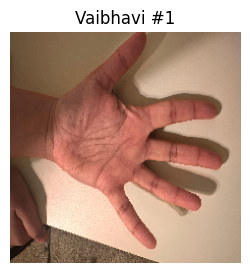

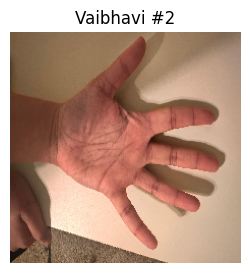

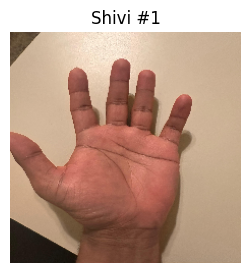

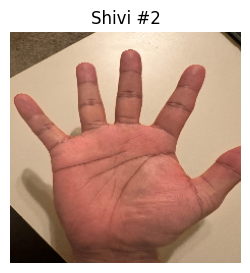

In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Track how many images we've shown per label
shown_count = defaultdict(int)

for i in range(len(data)):
    label = labels[i]
    if shown_count[label] < 2:
        shown_count[label] += 1
        count = shown_count[label]  # 1-based per person

        plt.figure(figsize=(3, 3))
        plt.imshow(cv2.cvtColor(data[i], cv2.COLOR_BGR2RGB))
        plt.title(f'{label_to_name[label]} #{count}')
        plt.axis('off')
        plt.show()


In [7]:
unique_labels = np.unique(labels)
num_classes = len(unique_labels)
print(f'Number of unique class labels: {num_classes}')

Number of unique class labels: 2


**Splitting Palmprint Data into Training and Testing Sets (80/20)**

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # 👈 ensures equal class distribution in train/test
)


**Feature Engineering: Normalization and One-Hot Encoding for Palmprint Images**

In [9]:
from tensorflow.keras.utils import to_categorical

# Normalize images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode labels
num_classes = len(np.unique(y_train))  # Use y_train here to avoid label leak

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


**Visualizing Class Distribution with Gaps and Colors (Bar Chart)**

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(y, label_to_name, title="Class Distribution"):
    # Convert one-hot to labels if needed
    if len(y.shape) > 1:
        y = np.argmax(y, axis=1)

    unique_labels, counts = np.unique(y, return_counts=True)
    num_classes = len(unique_labels)

    # Get class names from label_to_name dict
    class_names = [label_to_name[label] for label in unique_labels]

    # Set positions and colors
    x_positions = np.arange(num_classes)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

    # Plot
    plt.figure(figsize=(8, 5))
    bars = plt.bar(x_positions, counts, color=colors)

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                 str(counts[i]), ha='center', va='bottom', fontsize=10)

    # Name-based x-axis
    plt.xticks(x_positions, class_names)
    plt.xlabel("Person")
    plt.ylabel("Sample Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


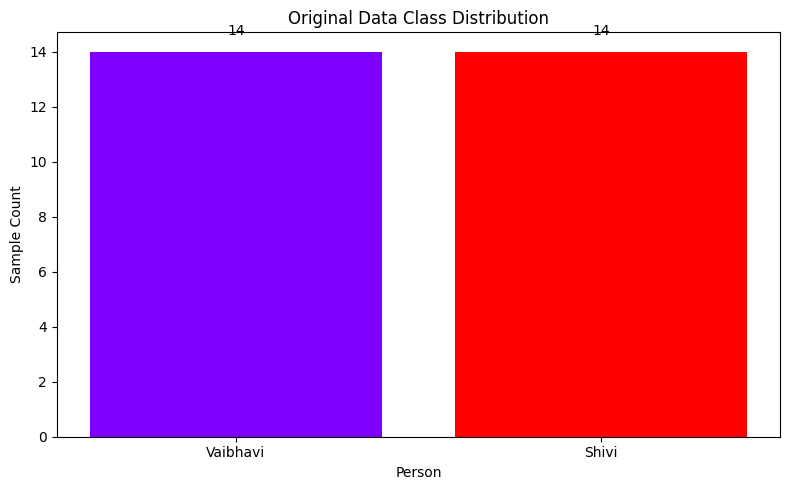

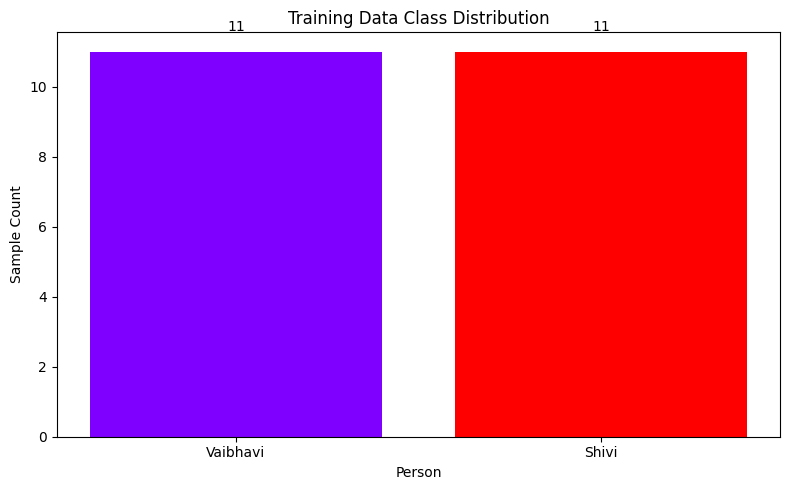

In [11]:
plot_class_distribution(labels, label_to_name, title="Original Data Class Distribution")
plot_class_distribution(y_train, label_to_name, title="Training Data Class Distribution")


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_class_distribution_with_gaussian(y, label_to_name, title="Class Distribution with Gaussian Overlay"):
    # Convert from one-hot if needed
    if len(y.shape) > 1:
        y = np.argmax(y, axis=1)

    # Count class occurrences
    unique_classes, counts = np.unique(y, return_counts=True)
    num_classes = len(unique_classes)
    class_names = [label_to_name[label] for label in unique_classes]

    # X positions with spacing
    gap = 0.5
    x_positions = np.arange(num_classes) * (1 + gap)

    # Plot bars
    plt.figure(figsize=(10, 6))
    bars = plt.bar(x_positions, counts, color=plt.cm.rainbow(np.linspace(0, 1, num_classes)), width=0.8)

    # Add count labels
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, count + 0.5, str(count),
                 ha='center', va='bottom', fontsize=9)

    # Gaussian overlay
    mean = np.mean(counts)
    std_dev = np.std(counts)
    x_vals = np.linspace(min(x_positions), max(x_positions), 200)
    y_vals = norm.pdf(x_vals, mean, std_dev)
    y_vals_scaled = y_vals * max(counts) / max(y_vals)
    plt.plot(x_vals, y_vals_scaled, color='black', linestyle='--', linewidth=2, label='Gaussian Fit')

    # Set labels
    plt.xticks(x_positions, class_names)
    plt.xlabel("Person")
    plt.ylabel("Sample Count")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


/Users/shravansailada/Desktop/project/new/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2046: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


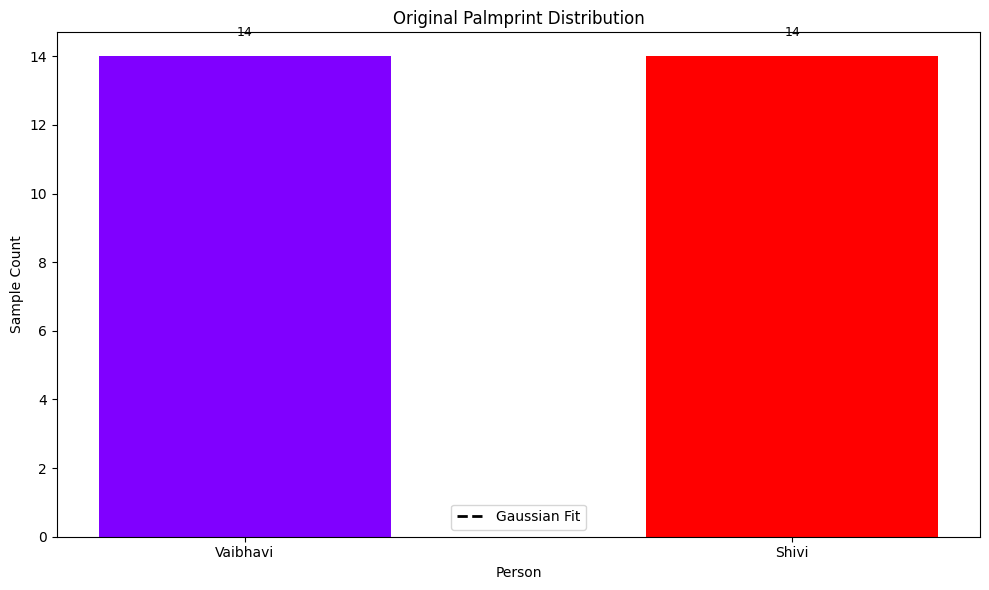

In [13]:
plot_class_distribution_with_gaussian(labels, label_to_name, title="Original Palmprint Distribution")


/Users/shravansailada/Desktop/project/new/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2046: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


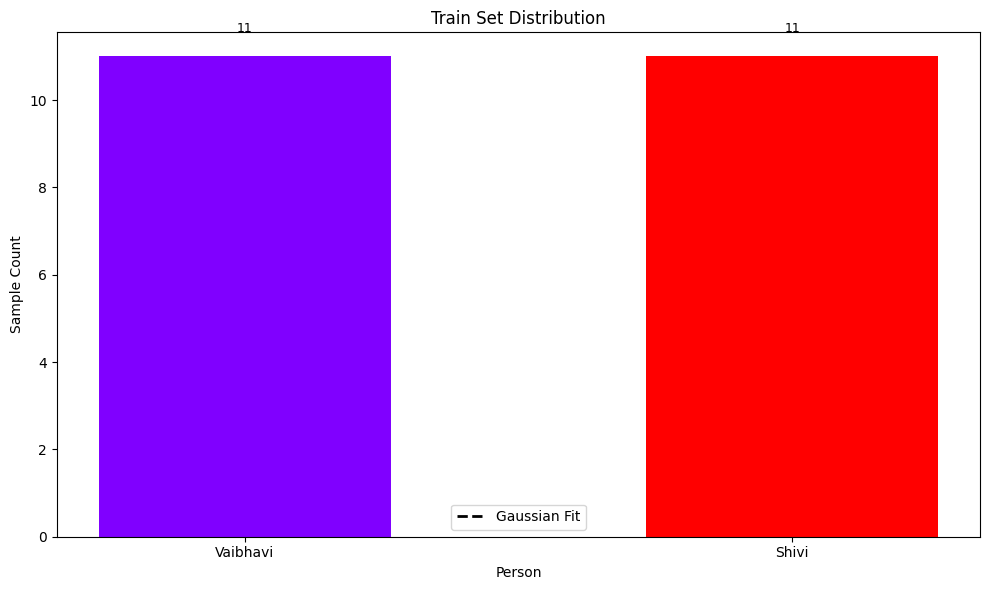

In [14]:
plot_class_distribution_with_gaussian(y_train, label_to_name, title="Train Set Distribution")


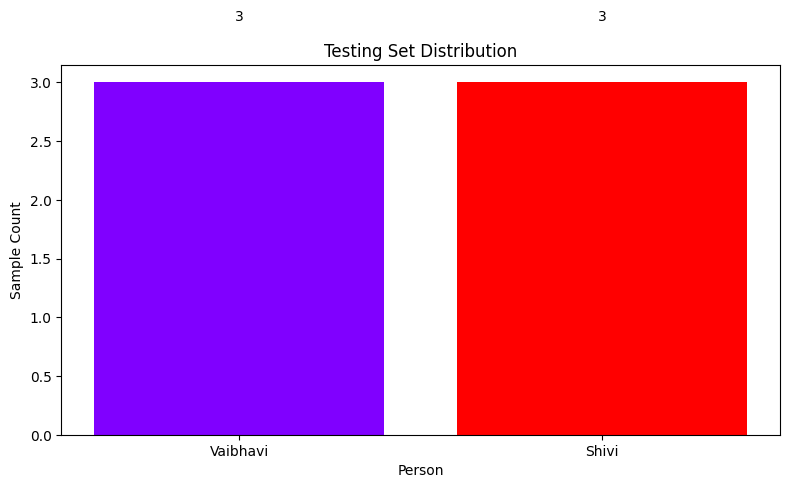

In [15]:
plot_class_distribution(np.argmax(y_test, axis=1), label_to_name, title='Testing Set Distribution')


**Enhancing Training Data Diversity: Image Augmentation for Palmprint Recognition**

In [16]:
# Import additional libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Data Augmentation
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
augmentor.fit(x_train)


In [17]:
# Learning Rate Schedule
def lr_schedule(epoch):
    return 0.001 * np.exp(-epoch / 10)

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)


In [18]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    filepath='/Users/shravansailada/Desktop/project/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


**Building the Palmprint Recognition Engine: Through the CNN Architecture **

In [19]:
def build_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [20]:
model = build_cnn_model((227, 227, 3), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/Users/shravansailada/Desktop/project/new/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 69984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    17,916,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,952,002 (68.48 MB)

 Trainable params: 17,951,810 (68.48 MB)

 Non-trainable params: 192 (768.00 B)

**Optimizing the CNN with Epochs, Batch Size, and Validation for Robustness**

In [21]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (22, 2)
y_test shape: (6, 2)


In [22]:
model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, lr_scheduler],
    verbose=1
)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.4545 - loss: 0.9868
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /Users/shravansailada/Desktop/project/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 151s 151s/step - accuracy: 0.4545 - loss: 0.9868 - val_accuracy: 0.5000 - val_loss: 5.9224 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9545 - loss: 0.8213
Epoch 2: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9545 - loss: 0.8213 - val_accuracy: 0.5000 - val_loss: 11.6506 - learning_rate: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 1.0000 - loss: 5.4186e-09
Epoch 3: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 1.0000 - loss: 5.4186e-09 - val_accuracy: 0.5000 - val_loss: 16.3575 - learning_rate: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - ac

**Evaluating the CNN's Performance on Unseen Data**

In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5000 - loss: 30.8466
Test accuracy: 50.00%


**Building the Upgraded Palmprint CNN with Keras**

In [24]:
# Define the updated CNN model
updatemodel = keras.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Optional: add more Conv/Pooling layers here for deeper model
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(units=num_classes, activation='softmax')
])

# Compile the model
updatemodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model architecture
updatemodel.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 69984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    17,916,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,952,002 (68.48 MB)

 Trainable params: 17,951,810 (68.48 MB)

 Non-trainable params: 192 (768.00 B)

**Training the Upgraded CNN with Advanced Techniques**

In [25]:
# Train the model with Data Augmentation, Learning Rate Schedule, and Model Checkpoint
history = updatemodel.fit(
    augmentor.flow(x_train, y_train, batch_size=32),  # make sure you're using 'augmentor', not 'datagen'
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[lr_scheduler, checkpoint],
    verbose=1
)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10


/Users/shravansailada/Desktop/project/new/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.5000 - loss: 0.9779
Epoch 1: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.9779 - val_accuracy: 0.5000 - val_loss: 6.6472 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7727 - loss: 3.6785
Epoch 2: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7727 - loss: 3.6785 - val_accuracy: 0.5000 - val_loss: 6.9750 - learning_rate: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8182 - loss: 8.7774
Epoch 3: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8182 - loss: 8.7774 - val_accuracy: 0.5000 - val_loss: 1.0856 - learning_rate: 8.1873e-04

Epoch 4: LearningRateSc

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step - accuracy: 0.9091 - loss: 3.8543 - val_accuracy: 1.0000 - val_loss: 0.0114 - learning_rate: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006703200460356394.
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9545 - loss: 0.0846
Epoch 5: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9545 - loss: 0.0846 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 6.7032e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0006065306597126335.
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9545 - loss: 0.1114
Epoch 6: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9545 - loss: 0.1114 - val_accuracy: 1.0000 - val_loss: 7.3819e-04 - learning_rate: 6.0653e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0005488116360940264.
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accur

In [26]:
# Evaluate the model
loss1, accuracy1 = updatemodel.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy1 * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 6.3294e-05
Test accuracy: 100.00%


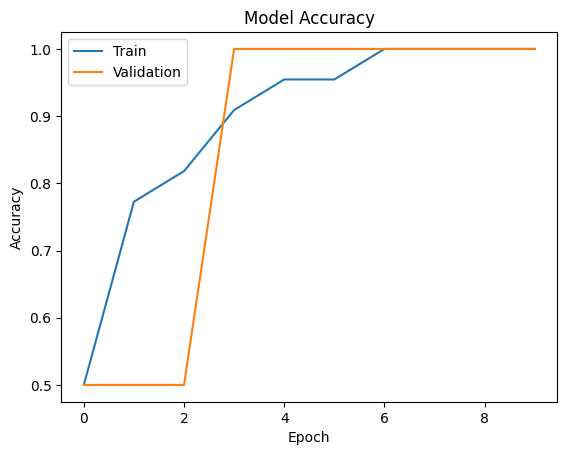

In [27]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
# Save model to a dedicated file (recommended .h5 or SavedModel format)
updatemodel.save('/Users/shravansailada/Desktop/project/palm_model.h5')


## TESTING

In [29]:
import cv2

# Load the trained model
model_path = '/Users/shravansailada/Desktop/project/palm_model.h5'
loaded_model = keras.models.load_model(model_path)

In [30]:
import cv2
import numpy as np

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (227, 227))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Shape becomes (1, 227, 227, 3)
    return img


**Function for Authenticating Users based on Palm Recognition**

In [31]:
def authenticate_palm(model, img_path, label_to_name):
    try:
        processed_img = preprocess_image(img_path)
        prediction = model.predict(processed_img)
        predicted_class = np.argmax(prediction)
        predicted_user = label_to_name[predicted_class]
        return predicted_user
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None


**Verifying User Identity with the Trained CNN Model **

In [32]:
testing_path = '/Users/shravansailada/Desktop/project/testing.jpeg'  # Replace with your test image path
predicted_user = authenticate_palm(loaded_model, testing_path, label_to_name)
print(f'Predicted User: {predicted_user}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Predicted User: Shivi


**Displaying the Test Palm and its Predicted Owner with Matplotlib**

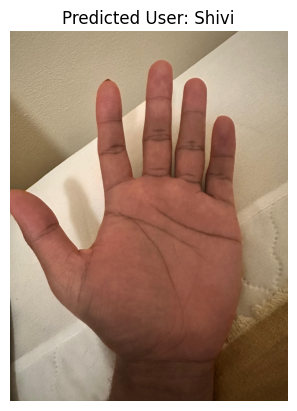

In [33]:
import matplotlib.pyplot as plt

def display_result(img_path, predicted_user):
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted User: {predicted_user}')
    plt.axis('off')
    plt.show()

display_result(testing_path, predicted_user)


In [34]:
pip install --upgrade opencv-python Pillow tensorflow


Note: you may need to restart the kernel to use updated packages.


**REGISTER NEW USER PALM PRINT**

In [35]:
import cv2
import os
import tkinter as tk
from tkinter import messagebox, simpledialog
from PIL import Image, ImageTk
import shutil
from tkinter import filedialog

** A User Interface for Selecting Palm Verification Input**

In [36]:
class VerifyOptionsDialog(tk.Toplevel):
    def __init__(self, parent):
        super().__init__(parent)
        self.title("Verification Options")
        self.geometry("400x200")
        self.configure(bg="#e0e0e0")

        self.label = tk.Label(self, text="Choose verification option:", font=("Arial", 16), bg="#2ecc71", fg="white", pady=10)
        self.label.pack(fill="x")

        button_frame = tk.Frame(self, bg="#e0e0e0")
        button_frame.pack(expand=True, pady=(10, 0))

        self.upload_button = tk.Button(button_frame, text="Upload Image", command=self.upload_image, font=("Arial", 14), bg="#3498db", fg="white", width=15)
        self.upload_button.pack(pady=10)

        self.capture_button = tk.Button(button_frame, text="Capture Image", command=self.capture_image, font=("Arial", 14), bg="#e74c3c", fg="white", width=15)
        self.capture_button.pack(pady=10)

        self.choice = None

    def upload_image(self):
        self.choice = "Upload Image"
        self.label.pack_forget()  # Remove the label from the layout
        self.destroy()

    def capture_image(self):
        self.choice = "Capture Image"
        self.label.pack_forget()  # Remove the label from the layout
        self.destroy()

**Building a Biometric Palm Recognition App: Registration, Verification, and User Management **

In [ ]:
import cv2
import os
import tkinter as tk
from tkinter import messagebox, filedialog
from PIL import Image, ImageTk
import shutil
import numpy as np
from keras.models import load_model

class PalmRegistrationApp:
    model_path = '/Users/shravansailada/Desktop/project/palm_model.h5'
    model = load_model(model_path)

    def __init__(self, root):
        self.root = root
        self.root.title("Palm Print Registration")
        self.root.geometry("600x700")
        self.root.configure(bg="#f0f0f0")
        self.label_to_register = None
        self.name_to_predict = None
        self.create_widgets()

    def create_widgets(self):
        tk.Label(self.root, text="Palm Registration System", font=("Arial", 20, "bold"), bg="#4CAF50", fg="white").pack(fill="x", pady=10)

        tk.Button(self.root, text="Register (Capture)", command=self.capture_both_palms, font=("Arial", 14)).pack(pady=10)
        tk.Button(self.root, text="Verify (Upload)", command=self.verify_with_upload, font=("Arial", 14)).pack(pady=10)
        tk.Button(self.root, text="Unregister", command=self.unregister_user, font=("Arial", 14)).pack(pady=10)

        self.canvas = tk.Canvas(self.root, width=400, height=400, bg="white")
        self.canvas.pack(pady=10)

    def capture_both_palms(self):
        self.label_to_register = self.get_next_label()
        for hand in ["left", "right"]:
            messagebox.showinfo("Capture", f"Get ready to capture your {hand.upper()} palm. Press SPACE to capture.")
            frame = self.capture_from_camera(hand)
            if frame is None:
                messagebox.showerror("Error", "Failed to capture image.")
                return

            user_dir = os.path.join('/Users/shravansailada/Desktop/project/register', self.label_to_register)
            os.makedirs(user_dir, exist_ok=True)
            img_path = os.path.join(user_dir, f"{self.label_to_register}_S_{hand[0].upper()}.jpg")
            cv2.imwrite(img_path, frame)
            self.display_image(frame)

        predicted_user, confidence = self.authenticate_palm(img_path)
        messagebox.showinfo("Registration Complete", f"Welcome {predicted_user}!\nRegistration successful.")

    def capture_from_camera(self, hand):
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            return None
        captured_frame = None
        while True:
            ret, frame = cap.read()
            if not ret:
                continue
            display_frame = cv2.putText(frame.copy(), f"Capture {hand.upper()} hand - Press SPACE", (10, 30),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            cv2.imshow("Live Feed", display_frame)
            key = cv2.waitKey(1) & 0xFF
            if key == 32:  # Space
                captured_frame = frame
                break
            elif key == 27:  # ESC
                break
        cap.release()
        cv2.destroyAllWindows()
        return captured_frame

    def verify_with_upload(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg *.png *.jpeg")])
        if not file_path:
            return
        predicted_user, confidence = self.authenticate_palm(file_path)
        if confidence >= 0.9:
            messagebox.showinfo("Verification", f"✅ Verified: {predicted_user}\nConfidence: {confidence:.2f}")
        else:
            messagebox.showwarning("Verification Failed", f"❌ Closest Match: {predicted_user}\nConfidence: {confidence:.2f}")

    def authenticate_palm(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (227, 227))
        img = img.astype("float32") / 255.0
        img = np.expand_dims(img, axis=0)
        prediction = self.model.predict(img)
        predicted_label = np.argmax(prediction)
        confidence = np.max(prediction)
        name = self.label_to_name().get(predicted_label, "Unknown")
        return name, confidence

    def unregister_user(self):
        label = tk.simpledialog.askstring("Unregister", "Enter user label to unregister (e.g. 001):")
        if not label:
            return
        user_dir = os.path.join('/Users/shravansailada/Desktop/project/register', label)
        if os.path.exists(user_dir):
            shutil.rmtree(user_dir)
            messagebox.showinfo("Unregistered", f"User {label} removed.")
        else:
            messagebox.showwarning("Not Found", f"No user found with label {label}.")

    def get_next_label(self, base_path='/Users/shravansailada/Desktop/project/register'):
        os.makedirs(base_path, exist_ok=True)
        existing = [int(folder.split('_')[0]) for folder in os.listdir(base_path) if folder.split('_')[0].isdigit()]
        return str(max(existing) + 1).zfill(3) if existing else '001'

    def label_to_name(self, base_path='/Users/shravansailada/Desktop/project/dataset'):
        mapping = {}
        for folder in os.listdir(base_path):
            try:
                label, name = folder.split("_", 1)
                mapping[int(label)] = name
            except:
                continue
        return mapping

    def display_image(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(image)
        img = img.resize((400, 400))
        tk_img = ImageTk.PhotoImage(img)
        self.canvas.create_image(0, 0, anchor="nw", image=tk_img)
        self.canvas.image = tk_img

if __name__ == "__main__":
    root = tk.Tk()
    app = PalmRegistrationApp(root)
    root.mainloop()
